In [ ]:
!pip install feature-engine

In [ ]:
!pip install memory_profiler

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.svm import LinearSVR,SVR
from sklearn.linear_model import LinearRegression
import time

In [2]:
df = pd.read_csv("./Concrete_Data_Yeh.csv")
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


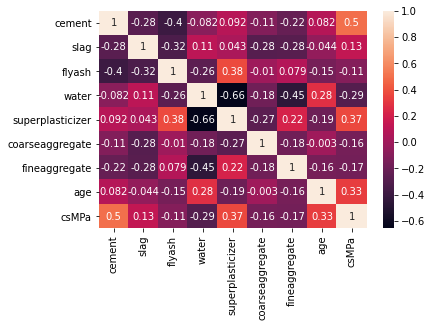

In [3]:
sns.heatmap(df.corr(),annot = True)

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [6]:
#feature scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled,columns = X_train.columns)
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled,columns = X_test.columns)
print(X_train_scaled.iloc[0:2])

     cement      slag    flyash  ...  coarseaggregate  fineaggregate       age
0 -1.160877  0.857387  0.982449  ...        -0.257462      -0.647520 -0.275673
1  1.308623 -0.602492  1.232598  ...        -1.926950      -0.273148 -0.275673

[2 rows x 8 columns]


In [7]:
# finding out correlated features with feature-engines SmartCorrelatedSelection
sel = SmartCorrelatedSelection(
            variables= None,
            method = 'pearson',
            missing_values= 'raise',
            selection_method = 'variance',
            estimator = None,
            scoring = 'neg_root_mean_squared_error',
            cv = 3,
            threshold = 0.65
)
sel.fit(X_train_scaled,y_train)
sel.features_to_drop_

['superplasticizer']

In [8]:
X_train_scaled = X_train_scaled.drop(["superplasticizer"], axis = 1)
X_test_scaled = X_test_scaled.drop(["superplasticizer"], axis = 1)

In [81]:
lin_svr = LinearSVR(dual = False, loss = "squared_epsilon_insensitive")
params = {
    "C" : [0.1, 0.2 , 0.5, 0.7, 1],
    "epsilon" : [0, 0.3, 0.5, 0.7, 1]
}
grid = GridSearchCV(lin_svr, param_grid= params, scoring= "neg_root_mean_squared_error", cv = 5, return_train_score= False)
grid.fit(X_train_scaled,y_train)
print(grid.best_estimator_)
print(grid.best_score_)

LinearSVR(C=0.5, dual=False, epsilon=0.3, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=1000, random_state=None, tol=0.0001, verbose=0)
-10.677019113795865


As it is evident from the heatmap that the features have mostly non-linear relationship with the target, so we'll try polynomial features for SVR and compare the performance with PolyReg

In [86]:
for i in range(2,6):
  poly_svr = SVR(kernel= 'poly', degree = i)
  score = cross_val_score(poly_svr,X_train_scaled,y_train,scoring = 'neg_root_mean_squared_error', cv= 3)
  print(i,score.mean(),score.std())

2 -15.733644520793687 0.8186915976459354
3 -12.639222678689398 0.3586256344553866
4 -15.24564059570725 0.5481736668305317
5 -13.993261262380301 0.34752742577854595


So from above we see degree 3 polynomial gives us the lowest loss. So we'll go choose degree = 3 for the polynomial

           params  mean_test_score  std_test_score
0    {'coef0': 0}       -12.356543        0.493429
1  {'coef0': 0.1}       -11.595685        0.497083
2  {'coef0': 0.2}       -10.669551        0.554779
3  {'coef0': 0.5}        -8.527528        0.667461
4  {'coef0': 0.7}        -7.933571        0.704672
5    {'coef0': 1}        -7.525055        0.746327


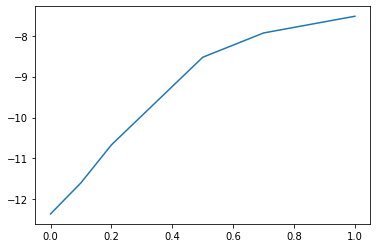

In [45]:
poly_svr = SVR(kernel= 'poly', degree = 3)
params1 = {
    "coef0" : [0, 0.1, 0.2, 0.5, 0.7, 1],
    
}

grid = GridSearchCV(poly_svr, param_grid= params1, scoring= "neg_root_mean_squared_error", cv = 5, return_train_score= False)
grid.fit(X_train_scaled,y_train)
result = pd.DataFrame(grid.cv_results_, columns= ["params", "mean_test_score", "std_test_score"])
print(result)
plt.plot(params1["coef0"],result.mean_test_score)

               params  mean_test_score  std_test_score
0   {'gamma': 'auto'}       -12.362804        0.533616
1  {'gamma': 'scale'}       -12.356543        0.493429


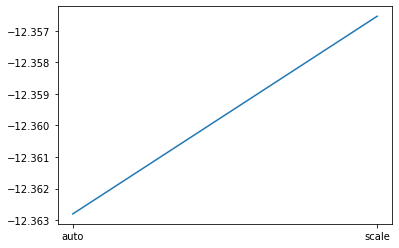

In [47]:
poly_svr = SVR(kernel= 'poly', degree = 3)
params2 = {
    "gamma" : ["auto", "scale"],
}
grid = GridSearchCV(poly_svr, param_grid= params2, scoring= "neg_root_mean_squared_error", cv = 5, return_train_score= False)
grid.fit(X_train_scaled,y_train)
result = pd.DataFrame(grid.cv_results_, columns= ["params", "mean_test_score", "std_test_score"])
print(result)
plt.plot(params2["gamma"],result.mean_test_score)

       params  mean_test_score  std_test_score
0  {'C': 0.1}       -15.382730        0.703095
1  {'C': 0.2}       -14.657642        0.583599
2  {'C': 0.5}       -13.440989        0.488050
3  {'C': 0.7}       -12.929876        0.476816
4    {'C': 1}       -12.356543        0.493429


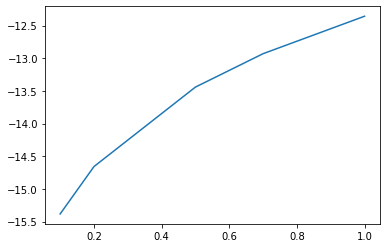

In [48]:
poly_svr = SVR(kernel= 'poly', degree = 3)
params3 = {
    "C" : [0.1, 0.2 , 0.5, 0.7, 1],
}
grid = GridSearchCV(poly_svr, param_grid= params3, scoring= "neg_root_mean_squared_error", cv = 5, return_train_score= False)
grid.fit(X_train_scaled,y_train)
result = pd.DataFrame(grid.cv_results_, columns= ["params", "mean_test_score", "std_test_score"])
print(result)
plt.plot(params3["C"],result.mean_test_score)

             params  mean_test_score  std_test_score
0    {'epsilon': 0}       -12.356746        0.497935
1  {'epsilon': 0.3}       -12.348041        0.492781
2  {'epsilon': 0.5}       -12.332927        0.499075
3  {'epsilon': 0.7}       -12.324038        0.501101
4    {'epsilon': 1}       -12.319815        0.500523


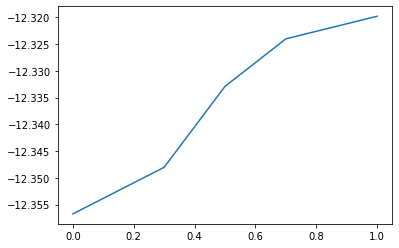

In [50]:
poly_svr = SVR(kernel= 'poly', degree = 3)
params4 = {
    "epsilon" : [0, 0.3, 0.5, 0.7, 1]
}
grid = GridSearchCV(poly_svr, param_grid= params4, scoring= "neg_root_mean_squared_error", cv = 5, return_train_score= False)
grid.fit(X_train_scaled,y_train)
result = pd.DataFrame(grid.cv_results_, columns= ["params", "mean_test_score", "std_test_score"])
print(result)
plt.plot(params4["epsilon"],result.mean_test_score)

In [60]:
poly_svr = SVR(kernel= 'poly', degree = 3)
params = {
    "coef0" : [0, 0.1, 0.2, 0.5, 0.7, 1],
    "C" : [0.1, 0.2 , 0.5, 0.7, 1],
    "epsilon" : [0, 0.3, 0.5, 0.7, 1]
}
grid = GridSearchCV(poly_svr, param_grid= params, scoring= "neg_root_mean_squared_error", cv = 5, return_train_score= False)
grid.fit(X_train_scaled,y_train)
print(grid.best_estimator_)
print(grid.best_score_)
poly_svr = grid.best_estimator_

SVR(C=1, cache_size=200, coef0=1, degree=3, epsilon=0, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-7.524854184670036


From above observations we see that-

1. Increasing coef0 decreases loss

2. No significant difference observed changing gamma

3. Decreasing 'C' i.e. regularization, loss decreases

4. Increasing'epsilon' the loss decreases

Now let's compare the performance of SVR with 'poly' kernel with Polynomial Regression for this dataset

In [77]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [78]:
%%time
%memit

poly_regressor = model = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 3, include_bias = False )),
        ("lin_reg", LinearRegression())
    ])
poly_regressor.fit(X_train_scaled,y_train)
y_pred = poly_regressor.predict(X_test_scaled)
loss = sqrt(mean_squared_error(y_test,y_pred))
print(loss)

peak memory: 233.46 MiB, increment: 0.00 MiB
6.551914863425191
CPU times: user 143 ms, sys: 59.3 ms, total: 202 ms
Wall time: 334 ms


In [79]:
%%time
%memit

poly_svr.fit(X_train_scaled,y_train)
y_pred = poly_svr.predict(X_test_scaled)
loss = sqrt(mean_squared_error(y_test,y_pred))
print(loss)

peak memory: 233.46 MiB, increment: 0.00 MiB
7.144983649952618
CPU times: user 203 ms, sys: 44.2 ms, total: 247 ms
Wall time: 398 ms


From above we see that both the execution time and loss is less if we use Polynomial regression instead of SVR with polynomial kernel